In [1]:
# This notebook supports input parameters for automatic report generation. The parameters must be variables in this
# cell, which has a special 'parameters' tag.
DATA_ROOT = r'G:\Shared drives\Covid-19 Spectrum Monitoring\Data'

HISTOGRAM_RESOLUTION_SWEEPS = 100
HISTOGRAM_POWER_LOW = -120
HISTOGRAM_POWER_HIGH = -20

dat_path_pattern = 'dUsVcuPP/*2020-11-*.dat'

figure_format = 'svg'

In [2]:
# hide the pink warnings in reports (comment to include them)
from environment import *
import figures
import histogram_analysis
from dwell_analysis import dBtopow, powtodB

bounds = (HISTOGRAM_POWER_LOW, HISTOGRAM_POWER_HIGH)

set_matplotlib_formats(figure_format)

display(widgets.HTML(f'This report was produced {time.strftime(time_format)}'));

def normalize(data,bystd=False):
    if isinstance(data,(pd.Series,pd.DataFrame)):
        v = data.values
    else:
        v = data
    if bystd:
        return (v-np.nanmedan(v))/v.nanmedian(np)
    else:
        return v/np.nanmean(v)

HTML(value='This report was produced 2021-10-19 12:33:06')

In [3]:
from scipy.signal import chirp, find_peaks, peak_widths, argrelmax

import matplotlib.pyplot as plt

def dwell_occupancy_by_threshold(dwell, prominence_dB=3, rel_height_dB=-6):
    if isinstance(dwell, (pd.Series, pd.DataFrame)):
        dwell = dwell.values
    dwell = np.squeeze(dwell)
    
    ii = np.arange(dwell.size)[:,np.newaxis]
    
    try:
        peaks, _ = find_peaks(powtodB(dwell), prominence=prominence_dB)
    except:
        print(dwell)
        raise

    rel_height = rel_height=1-10**(rel_height_dB/10.)
    widths, widths_heights, ips_left, ips_right = peak_widths(dwell, peaks, rel_height)

    active_inds = (
        (ii >= np.ceil(ips_left) ) & (ii <= np.floor(ips_right))
    ).any(axis=1).astype('bool')
    
    on = dwell[active_inds]
    off = dwell[~active_inds]

    counts, bins = np.histogram(widths, bins=np.arange(40))

    width_info = pd.Series(
        counts,
        index=bins[:-1]
    )

    width_info['Off power'] = powtodB(np.median(off))
    return width_info


# %timeit -n1 -r1 glob.iloc[:2000].apply(dwell_occupancy_by_threshold, axis=1)

In [4]:
def plot_dwell_envelopes(dwells, label):
    idx_time = dwells.index.names.index('Time')

    def strftime_from_idx(idx):
        return idx[idx_time].strftime(time_format.replace(' ','\n'))

    fig, (ax1,ax2) = subplots(1,2,figsize=figsize_fullwidth)

    maxima = dwells.mean(axis=1)

    plot_tagged_dwell_window(dwells.loc(axis=0)[maxima.idxmax()], compare=False, tag=False, ax=ax1, color='b')
    plot_tagged_dwell_window(dwells.loc(axis=0)[maxima.idxmin()], compare=False, tag=False, ax=ax1, color='g')

    ax1.legend(['max', 'min'])

    (
        powtodB(maxima)
        .reset_index(['Site','Path','Frequency','Sweep'],drop=True)
        .plot(ax=ax2, rasterized=True, color='k')
    )

    # maximum by dwell window
    ax2.xaxis.get_label().set_visible(False)
    figures.xaxis_concise_dates(fig, ax2, adjacent_offset=False);

    extra_ticks = list(
        matplotlib.dates.date2num([maxima.idxmax()[idx_time], maxima.idxmin()[idx_time]])
    )

    draw()

    figures.subplot_title(ax1, f'Dwell envelope extrema ({label})')
    figures.subplot_title(ax2, f'Dwell window maxima ({label})')

    xticks(
        ticks = list(xticks()[0]) + extra_ticks,
        labels = [t.get_text() for t in xticks()[1]] + ['', '']
    )
    # ax.xaxis.get_ticklabels()[-2].set_rotation(90)
    label = ax2.xaxis.get_ticklabels()[-2]
    line = ax2.xaxis.get_ticklines()[-4]
    label.set_position((label.get_position()[0], .1))
    label.set_horizontalalignment('left')
    label.set_color('b')
    line.set_markeredgecolor('b')
    line.set_markerfacecolor('b')

    label = ax2.xaxis.get_ticklabels()[-1]
    line = ax2.xaxis.get_ticklines()[-2]
    label.set_position((label.get_position()[0], .1))
    label.set_horizontalalignment('left')
    # ax.xaxis.get_ticklabels()[-1].set_rotation(90)
    label.set_color('g')
    line.set_markeredgecolor('g')
    line.set_markerfacecolor('g')

    ax2.axvline(maxima.idxmax()[3], color='b', lw=1.5, ls=':')
    ax2.axvline(maxima.idxmin()[3], color='g', lw=1.5, ls=':')

    return fig

def plot_tagged_dwell_window(dwell, prominence_dB=3, color=None, rel_height_dB=-6, compare=True, tag=True, ax=None):
    x = dwell.values
    x = np.squeeze(dwell.values)

    elapsed = (dwell.index.values - dwell.index.values[0])*1000
    
    ii = np.arange(x.size)[:,np.newaxis]

    peaks, _ = find_peaks(powtodB(x), prominence=prominence_dB)

    rel_height = rel_height=1-10**(rel_height_dB/10.)
    widths, widths_heights, ips_left, ips_right = peak_widths(x, peaks, rel_height)

    active_inds = (
        (ii >= np.ceil(ips_left) ) & (ii <= np.floor(ips_right))
    ).any(axis=1).astype('bool')

    on = x[active_inds]
    off = x[~active_inds]

    counts, bins = np.histogram(widths, bins=np.arange(40))

    width_info = pd.Series(
        counts,
        index=bins[:-1]
    )

    width_info['Off power'] = powtodB(np.median(off))
    ips_left = np.array(ips_left).astype(int)
    ips_right = np.ceil(np.array(ips_right)).astype(int)

    if ax is None:
        fig, ax = subplots()

    ax.plot(elapsed, powtodB(x), marker='.', ms=2, color=color)

    if tag:
        ax.plot(elapsed[peaks], powtodB(x[peaks]), "x")
        ax.hlines(powtodB(widths_heights), elapsed[ips_left], elapsed[ips_right], ls=':', color=color)
    ax.set_ylabel(figures.power_label)
    ax.set_xlabel('Dwell window time elapsed (ms)')    

    if compare:
        figure()
        plot(elapsed[active_inds], powtodB(on), '.')
        plot(elapsed[~active_inds], powtodB(off), '.')
        legend(
            ['Samples tagged within peaks', 'Tagged outside of peaks'],
            title=(
                f"Site {dwell.name[0]}\n"
                f"{dwell.name[-1]:0.1f} MHz\n"
                f"{str(ts)})"
            )
        )
        ylabel(figures.power_label)
        xlabel('Dwell window time elapsed (ms)')

        print(np.mean(powtodB(on)), np.median(powtodB(off)))

    return ax

def plot_band_dwell_heatmap(band_dwells, label_text, ax=None):
    if ax is None:
        fig, ax = subplots(figsize=figsize_fullwidth)

    maxima = band_dwells.mean(axis=1)

    band_dwell_maxhold = band_dwells.rolling(30).max().shift(-15).iloc[::30]

    cmap = matplotlib.cm.get_cmap("magma")

    c = ax.pcolormesh(
        band_dwell_maxhold.index.get_level_values('Time'),
        1000*(band_dwell_maxhold.columns.values-band_dwells.columns.values[0]),
        powtodB(band_dwell_maxhold.T.values),
        cmap=cmap,
        # norm=plot_norm,
        rasterized=True,
    )
    extra_ticks = list(
        matplotlib.dates.date2num([maxima.idxmax()[3], maxima.idxmin()[3]])
    )

    ax.axvline(maxima.idxmax()[3], color='b', lw=1.5, ls=':')
    ax.axvline(maxima.idxmin()[3], color='g', lw=1.5, ls=':')

    draw()

    figures.subplot_title(ax, f'Band power, 5-minute maxima ({label_text})')

    # add in markers for the min and max slices
    xticks(
        ticks = list(xticks()[0]) + extra_ticks,
        labels = [t.get_text() for t in xticks()[1]] + ['', '']
    )
    # ax.xaxis.get_ticklabels()[-2].set_rotation(90)
    label = ax.xaxis.get_ticklabels()[-2]
    line = ax.xaxis.get_ticklines()[-4]
    label.set_position((label.get_position()[0], .1))
    label.set_horizontalalignment('left')
    label.set_color('b')
    line.set_markeredgecolor('b')
    line.set_markerfacecolor('b')

    label = ax.xaxis.get_ticklabels()[-1]
    line = ax.xaxis.get_ticklines()[-2]
    label.set_position((label.get_position()[0], .1))
    label.set_horizontalalignment('left')
    # ax.xaxis.get_ticklabels()[-1].set_rotation(90)
    label.set_color('g')
    line.set_markeredgecolor('g')
    line.set_markerfacecolor('g')

    ylabel('Dwell time elapsed (ms)')
    fig.colorbar(c, cmap=cmap, ax=ax, label="Band power (dBm/4 MHz)")
    
    fc = band_dwells.index.levels[0][0]

    return ax

In [5]:
dwells = read_dat.swept_power_glob(Path(DATA_ROOT), dat_path_pattern)

# # there is slight error in the achieved frequency; map intended nearby frequency
# # to achieved frequency
fc_map = dict(zip(np.round(dwells.index.levels[2],1),dwells.index.levels[2]))


KeyboardInterrupt: 

## LTE uplink bands

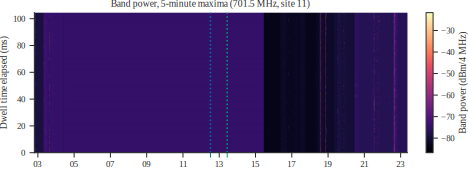

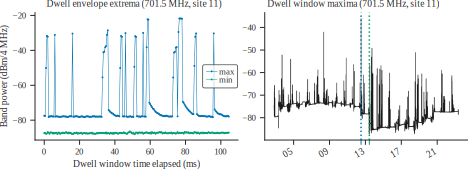

In [336]:
fc = dwells.loc(axis=0)[:,:,[fc_map[fc] for fc in fc_lte_ul]].mean(axis=1).idxmax()[2]

band_dwells = dwells.loc(axis=0)[:,:,[fc_map[fc]]]
label = f'{fc} MHz, site {band_dwells.index.levels[0][0]}'

ax = plot_band_dwell_heatmap(band_dwells, label)

plot_dwell_envelopes(band_dwells, label);

In [473]:

durations = occupancy_duration_by_threshold(band_dwells, (-70, -65, -60, -55, -50))
durations.shape

        # counts, bins = np.histogram(duration, bins=np.arange(1,50)*Ts)
        # semilogy(bins[:-1]*1e3, (counts/counts.sum())[::-1].cumsum()[::-1], marker='.', label=f'{threshold_dB} dBm threshold')


    # legend(title='Occupancy threshold')
    # xlabel('Occupancy duration (ms)')
    # ylabel('Fraction exceeding duration')

    # i0.shape, i1.shape

In [17]:
fc_map = dict(zip(np.round(od.index.levels[0],1),od.index.levels[0]))
[fc_map[fc] for fc in fc_lte_dl]

[734.0, 739.0, 751.0, 866.2999877929688, 887.5]

In [12]:
od.index.levels[0]

Float64Index([            701.5,             709.0,             734.0,
                          739.0,             751.0,             782.0,
              821.2999877929688,             842.5, 866.2999877929688,
                          887.5,            2412.0,            2437.0,
                         2462.0,            2695.0,            5170.0,
                         5190.0,            5210.0,            5230.0,
                         5240.0,            5775.0,            5795.0],
             dtype='float64', name='Frequency')

In [6]:
od = pd.read_parquet(r'd:\dkuester\covidscratch\occupancy durations.parquet')

In [9]:
od.memory_usage()/1e6

Index    810.509042
-75      153.967304
-70      153.967304
-65      153.967304
-60      153.967304
-55      153.967304
-50      153.967304
dtype: float64

In [480]:
fc_lte_dl

[734, 739, 751, 866.3, 887.5]

In [489]:
od.notnull().sum(axis=0)

Threshold (dB)
-75    3901614
-70    2736831
-65    3097846
-60    7500130
-55    3839876
-50     510142
dtype: int64

In [442]:
start_delay = pd.TimedeltaIndex(wide.columns.values[i1[:,0]], unit='s')
idx = wide.index[i0[:,0]].droplevel(['Sweep','Path']).remove_unused_levels()
times = idx.get_level_values('Time') + start_delay

new_idx = idx.set_levels(idx.get_level_values('Time').values + start_delay.values, level='Time')
# new_idx = pd.MultiIndex(
#     levels=tuple(idx.levels[:2]) + (times,),
#     codes = idx.codes,#tuple(idx.codes[:2]) + (np.argsort(times),),
#     names = idx.names
# )

In [444]:
ts = idx.get_level_values('Time')

In [452]:
ts.astype('float64')

TypeError: Cannot cast DatetimeIndex to dtype float64

In [443]:
new_idx.sort_values()[-1], idx.sort_values()[-1]

((11, 701.5, Timestamp('2020-11-15 04:23:17.639977920')),
 (11,
  701.5,
  Timestamp('2020-11-22 15:53:32.818860800-0700', tz='America/Denver')))

In [409]:
times[-1]

Timestamp('2020-11-22 15:53:33.094860800-0700', tz='America/Denver')

In [410]:
idx.get_level_values('Time')[-1]

Timestamp('2020-11-22 15:53:32.818860800-0700', tz='America/Denver')

In [321]:
idx.levels[2][i0[:,0]].values[:] = idx.levels[2][i0[:,0]] + start_delay

In [284]:
start_delay = pd.TimedeltaIndex(wide.columns.values[i1[:,0]], unit='s')
idx = wide.index[i0[:,0]].droplevel(['Sweep','Path'])

# sweep_timestamp + start_delay

In [265]:
pd.DataFrame(ret)

,-70,-65,-60,-55,-50
0,0.0005,0.0010,0.0010,0.0010,0.0010
1,0.0005,0.0010,0.0015,0.0010,0.0025
2,0.0005,0.0010,0.0015,0.0005,0.0025
3,0.0005,0.0010,0.0005,0.0020,0.0005
4,0.0005,0.0015,0.0010,0.0005,0.0005
...,...,...,...,...,...
11608,0.0010,NaN,NaN,NaN,NaN
11609,0.0015,NaN,NaN,NaN,NaN
11610,0.0005,NaN,NaN,NaN,NaN
11611,0.0005,NaN,NaN,NaN,NaN


## LTE downlink bands

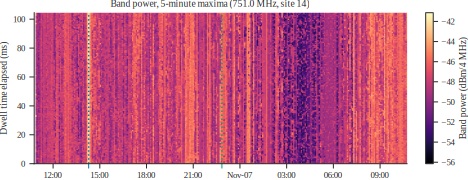

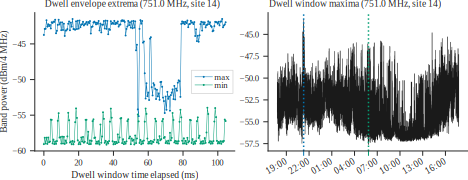

In [27]:
fc = dwells.loc(axis=0)[:,:,[fc_map[fc] for fc in fc_lte_dl]].mean(axis=1).idxmax()[2]

band_dwells = dwells.loc(axis=0)[:,:,[fc_map[fc]]]
label = f'{fc} MHz, site {band_dwells.index.levels[0][0]}'

ax = plot_band_dwell_heatmap(band_dwells, label)

plot_dwell_envelopes(band_dwells, label);

## 2.4 GHz ISM band

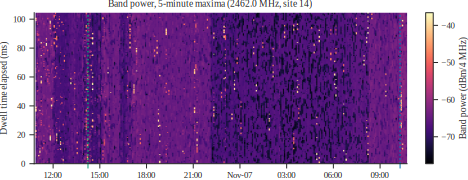

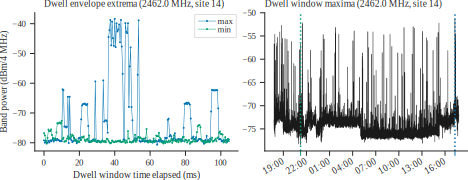

In [28]:
# find the most active center frequency in the band
fc = dwells.loc(axis=0)[:,:,[fc_map[fc] for fc in fc_ism]].max(axis=1).idxmax()[2]

band_dwells = dwells.loc(axis=0)[:,:,[fc_map[fc]]]
label = f'{fc} MHz, site {band_dwells.index.levels[0][0]}'

plot_band_dwell_heatmap(band_dwells, label)
plot_dwell_envelopes(band_dwells, label);

## Quiet band

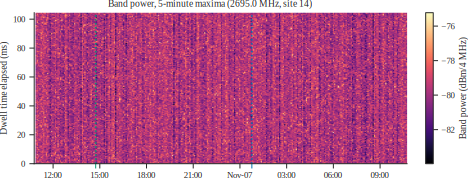

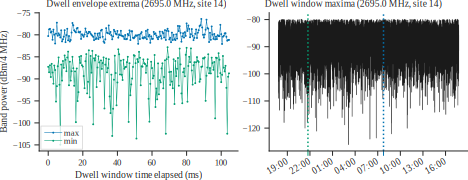

In [29]:
for fc in [fc_quiet]:
    band_dwells = dwells.loc(axis=0)[:,:,fc_map[fc]]
    label = f'{fc:0.1f} MHz, site {band_dwells.index.levels[0][0]}'

    plot_band_dwell_heatmap(band_dwells, label)
    plot_dwell_envelopes(band_dwells, label);

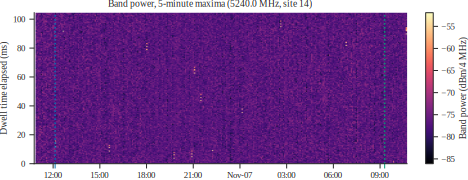

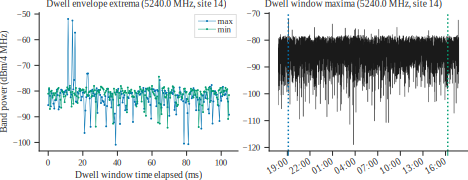

In [30]:
fc = dwells.loc(axis=0)[:,:,[fc_map[fc] for fc in fc_unii]].max(axis=1).idxmax()[2]

band_dwells = dwells.loc(axis=0)[:,:,[fc_map[fc]]]
label = f'{fc} MHz, site {band_dwells.index.levels[0][0]}'

plot_band_dwell_heatmap(band_dwells, label)
plot_dwell_envelopes(band_dwells, label);